<a href="https://colab.research.google.com/github/aasthad27/PCOS_DETECTION/blob/main/PCOS_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [48]:
import warnings
warnings.filterwarnings('ignore')
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.0 MB/s eta 0:00:00


In [49]:
from collections import Counter
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
import lightgbm
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [50]:
inf = pd.read_csv('/content/PCOS_infertility.csv')
woinf = pd.read_excel('/content/PCOS_data_without_infertility (2).xlsx', sheet_name= 'Full_new')

In [51]:
# Looking at the data with infertile patients.

inf.head()

,Sl. No,Patient File No.,PCOS (Y/N),I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),AMH(ng/mL)
0,1,10001,0,1.99,1.99,2.07
1,2,10002,0,60.80,1.99,1.53
2,3,10003,1,494.08,494.08,6.63
3,4,10004,0,1.99,1.99,1.22
4,5,10005,0,801.45,801.45,2.26


In [52]:
# Looking at the data with non-infertile patients.

woinf.head()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 44
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,...,1.0,0,110,80,3,3,18.0,18.0,8.5,NaN
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,...,0.0,0,120,70,3,5,15.0,14.0,3.7,NaN
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,...,1.0,0,120,80,13,15,18.0,20.0,10.0,NaN
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,...,0.0,0,120,70,2,2,15.0,14.0,7.5,NaN
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,...,0.0,0,120,80,3,4,16.0,14.0,7.0,NaN


In [53]:
# Looking at the columns of data with non-infertile patients.

woinf.columns


Index(['Sl. No', 'Patient File No.', 'PCOS (Y/N)', ' Age (yrs)', 'Weight (Kg)',
       'Height(Cm) ', 'BMI', 'Blood Group', 'Pulse rate(bpm) ',
       'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Cycle length(days)',
       'Marraige Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions',
       '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)',
       'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio',
       'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)',
       'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)',
       'BP _Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)',
       'Unnamed: 44'],
      dtype='object')

In [54]:
# Merging the two files as per patient file no.
# The files were sorted into two based on patients with infertility and without infertility

data = pd.merge(woinf,inf, on='Patient File No.', suffixes={'','_wo'},how='left')

In [55]:
data =data.drop(['Unnamed: 44', 'Sl. No_wo', 'PCOS (Y/N)_wo', '  I   beta-HCG(mIU/mL)_wo','II    beta-HCG(mIU/mL)_wo', 'AMH(ng/mL)_wo'], axis=1)

In [56]:
# Changing the title of the properties.

data = data.rename(columns = {"PCOS (Y/N)":"Target"})

In [57]:
# Looking at the merged data.

data.head()

,Sl. No,Patient File No.,Target,Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0


In [58]:
# Dropping unnecessary features.

data = data.drop(["Sl. No","Patient File No."],axis = 1)

In [59]:
data.info(verbose = True, null_counts = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 42 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Target                  int64  
 1    Age (yrs)              int64  
 2   Weight (Kg)             float64
 3   Height(Cm)              float64
 4   BMI                     float64
 5   Blood Group             int64  
 6   Pulse rate(bpm)         int64  
 7   RR (breaths/min)        int64  
 8   Hb(g/dl)                float64
 9   Cycle(R/I)              int64  
 10  Cycle length(days)      int64  
 11  Marraige Status (Yrs)   float64
 12  Pregnant(Y/N)           int64  
 13  No. of aborptions       int64  
 14    I   beta-HCG(mIU/mL)  float64
 15  II    beta-HCG(mIU/mL)  object 
 16  FSH(mIU/mL)             float64
 17  LH(mIU/mL)              float64
 18  FSH/LH                  float64
 19  Hip(inch)               int64  
 20  Waist(inch)             int64  
 21  Waist:Hip Ratio         float64
 22  TS

In [60]:
# Having a look at the data with dtype objects.

data["AMH(ng/mL)"].head() 

0    2.07
1    1.53
2    6.63
3    1.22
4    2.26
Name: AMH(ng/mL), dtype: object

In [61]:
# Similarly,

data["II    beta-HCG(mIU/mL)"].head()

0      1.99
1      1.99
2    494.08
3      1.99
4    801.45
Name: II    beta-HCG(mIU/mL), dtype: object

In [62]:
# Dealing with categorical values.
# In this database the type objects are numeric values saved as strings.
# So I am just converting it into a numeric value.

data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')

data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')
# Dealing with missing values. 
# Filling NA values with the median of that feature.

data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(),inplace=True)

data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(),inplace=True)

data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(),inplace=True)

data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(),inplace=True)

In [63]:
# Clearing up the extra space in the column names.

data.columns = [col.strip() for col in data.columns]

In [64]:
colors = ['#670067','#008080']

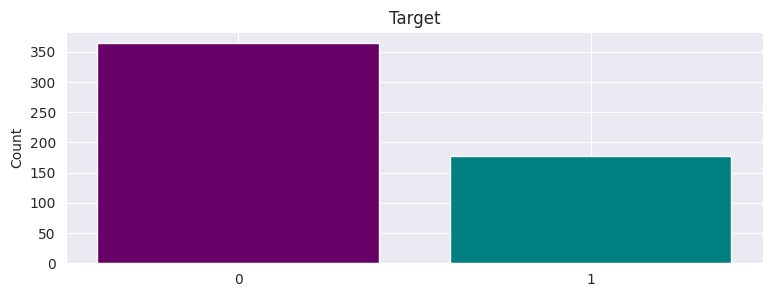

Target: 
 0    364
1    177
Name: Target, dtype: int64


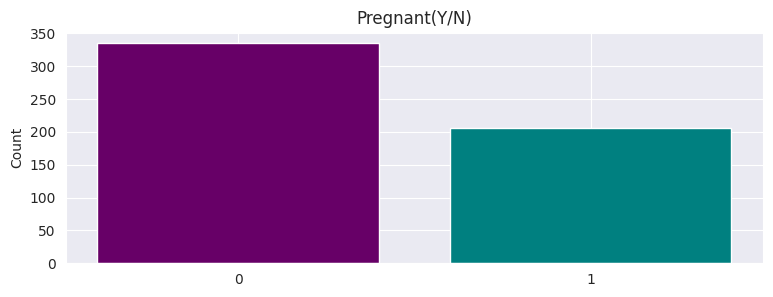

Pregnant(Y/N): 
 0    335
1    206
Name: Pregnant(Y/N), dtype: int64


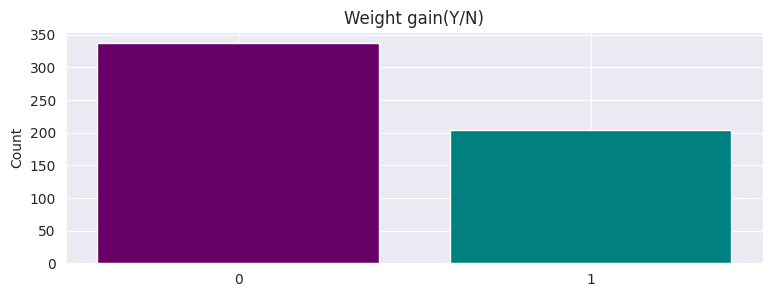

Weight gain(Y/N): 
 0    337
1    204
Name: Weight gain(Y/N), dtype: int64


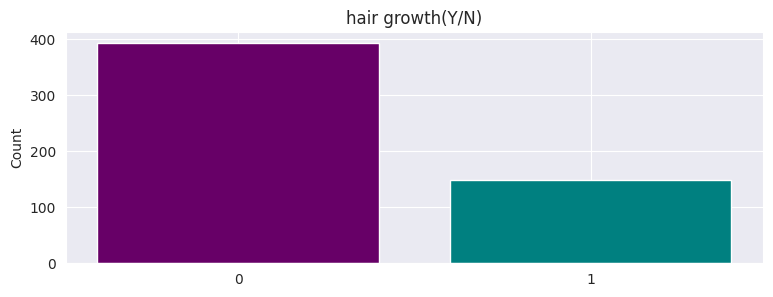

hair growth(Y/N): 
 0    393
1    148
Name: hair growth(Y/N), dtype: int64


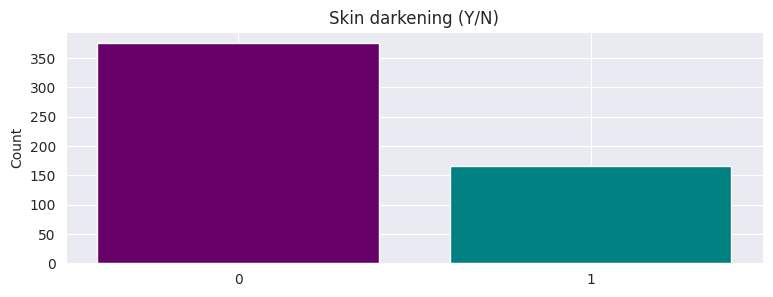

Skin darkening (Y/N): 
 0    375
1    166
Name: Skin darkening (Y/N), dtype: int64


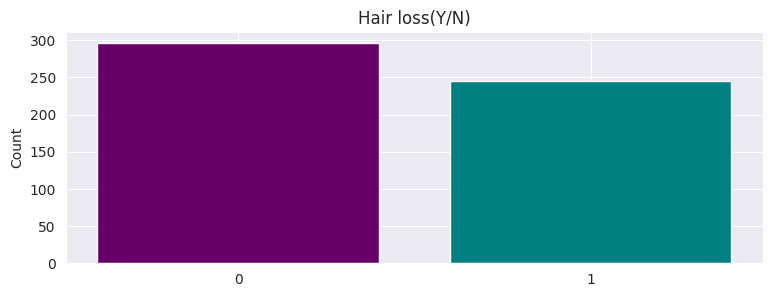

Hair loss(Y/N): 
 0    296
1    245
Name: Hair loss(Y/N), dtype: int64


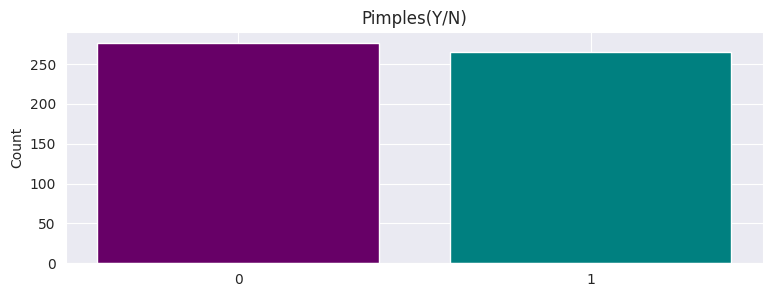

Pimples(Y/N): 
 0    276
1    265
Name: Pimples(Y/N), dtype: int64


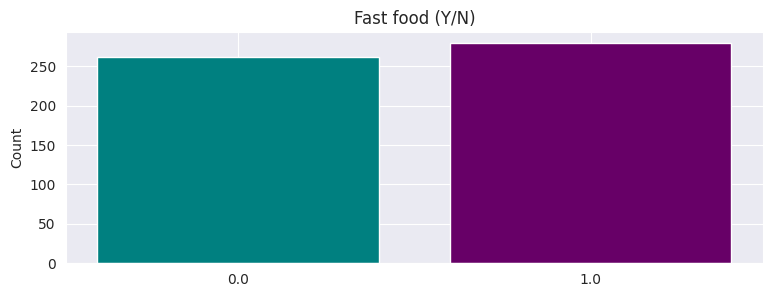

Fast food (Y/N): 
 1.0    279
0.0    262
Name: Fast food (Y/N), dtype: int64


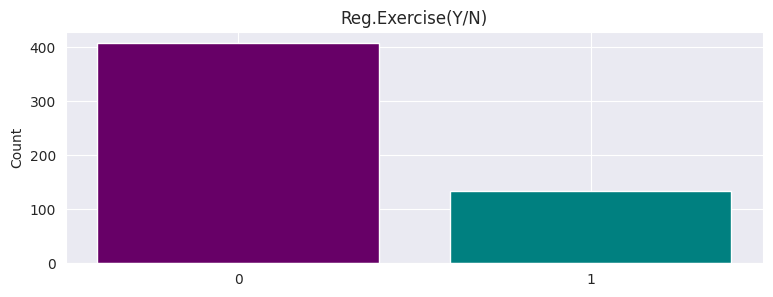

Reg.Exercise(Y/N): 
 0    407
1    134
Name: Reg.Exercise(Y/N), dtype: int64


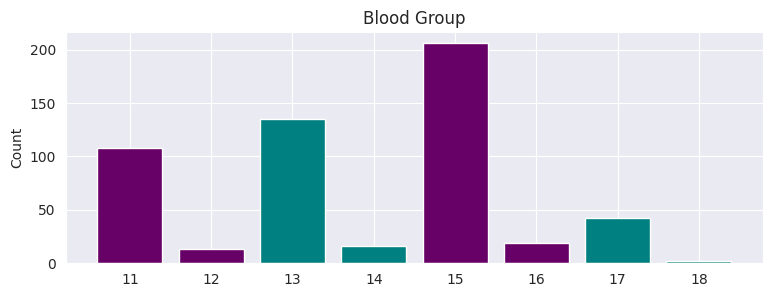

Blood Group: 
 15    206
13    135
11    108
17     42
16     19
14     16
12     13
18      2
Name: Blood Group, dtype: int64


In [65]:
def bar_plot(variable):
    """
     input: variable example : Target
     output: bar plot & value count
     
    """
    # Get feature
    var = data[variable]
    # Count number of categorical variable(value/sample)
    varValue = var.value_counts()
    # Visualize
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index,varValue,color=colors)
    plt.xticks(varValue.index,varValue.index.values)
    plt.ylabel("Count")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable,varValue))
category = ["Target", "Pregnant(Y/N)", "Weight gain(Y/N)", "hair growth(Y/N)", "Skin darkening (Y/N)", "Hair loss(Y/N)", "Pimples(Y/N)", "Fast food (Y/N)", "Reg.Exercise(Y/N)", "Blood Group"]
for c in category:
    bar_plot(c)

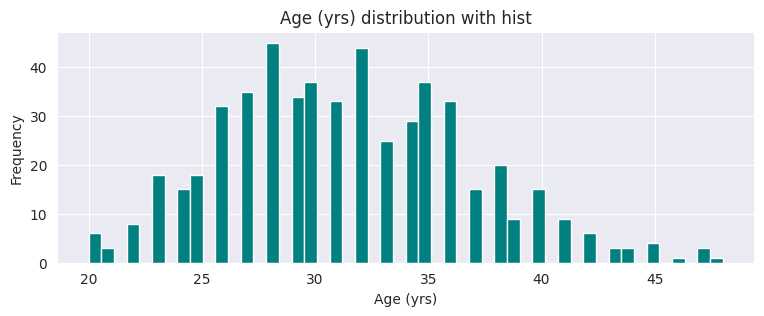

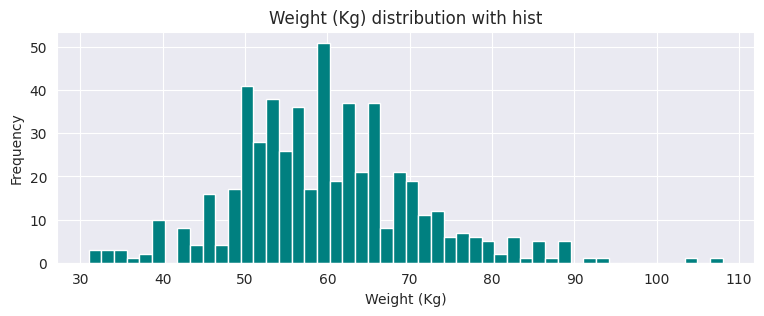

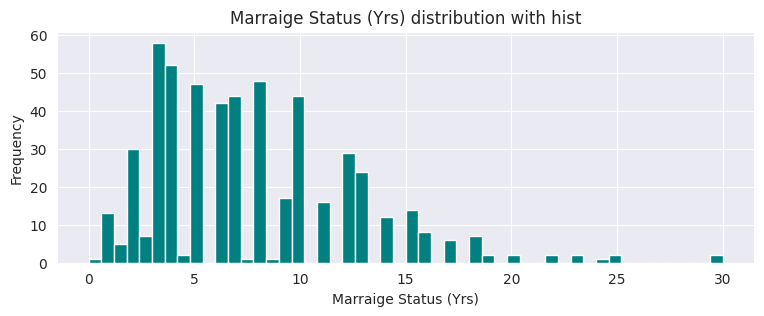

In [66]:
def plot_hist(variable):
    plt.figure(figsize = (9,3))
    plt.hist(data[variable], bins = 50,color=colors[1])
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(variable))
    plt.show()
numericVar = ["Age (yrs)", "Weight (Kg)","Marraige Status (Yrs)"]
for n in numericVar:
    plot_hist(n)

In [67]:
# Having a look at some basic statistical details.

data.describe()

,Target,Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,...,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,0.327172,31.430684,59.637153,156.484835,24.311285,13.802218,73.247689,19.243993,11.160037,2.560074,...,0.489834,0.515712,0.247689,114.661738,76.927911,6.129390,6.641405,15.018115,15.451701,8.475915
std,0.469615,5.411006,11.028287,6.033545,4.056399,1.840812,4.430285,1.688629,0.866904,0.901950,...,0.500359,0.500216,0.432070,7.384556,5.574112,4.229294,4.436889,3.566839,3.318848,2.165381
min,0.000000,20.000000,31.000000,137.000000,12.417882,11.000000,13.000000,16.000000,8.500000,2.000000,...,0.000000,0.000000,0.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28.000000,52.000000,152.000000,21.641274,13.000000,72.000000,18.000000,10.500000,2.000000,...,0.000000,0.000000,0.000000,110.000000,70.000000,3.000000,3.000000,13.000000,13.000000,7.000000
50%,0.000000,31.000000,59.000000,156.000000,24.238227,14.000000,72.000000,18.000000,11.000000,2.000000,...,0.000000,1.000000,0.000000,110.000000,80.000000,5.000000,6.000000,15.000000,16.000000,8.500000
75%,1.000000,35.000000,65.000000,160.000000,26.634958,15.000000,74.000000,20.000000,11.700000,4.000000,...,1.000000,1.000000,0.000000,120.000000,80.000000,9.000000,10.000000,18.000000,18.000000,9.800000
max,1.000000,48.000000,108.000000,180.000000,38.900000,18.000000,82.000000,28.000000,14.800000,5.000000,...,1.000000,1.000000,1.000000,140.000000,100.000000,22.000000,20.000000,24.000000,24.000000,18.000000


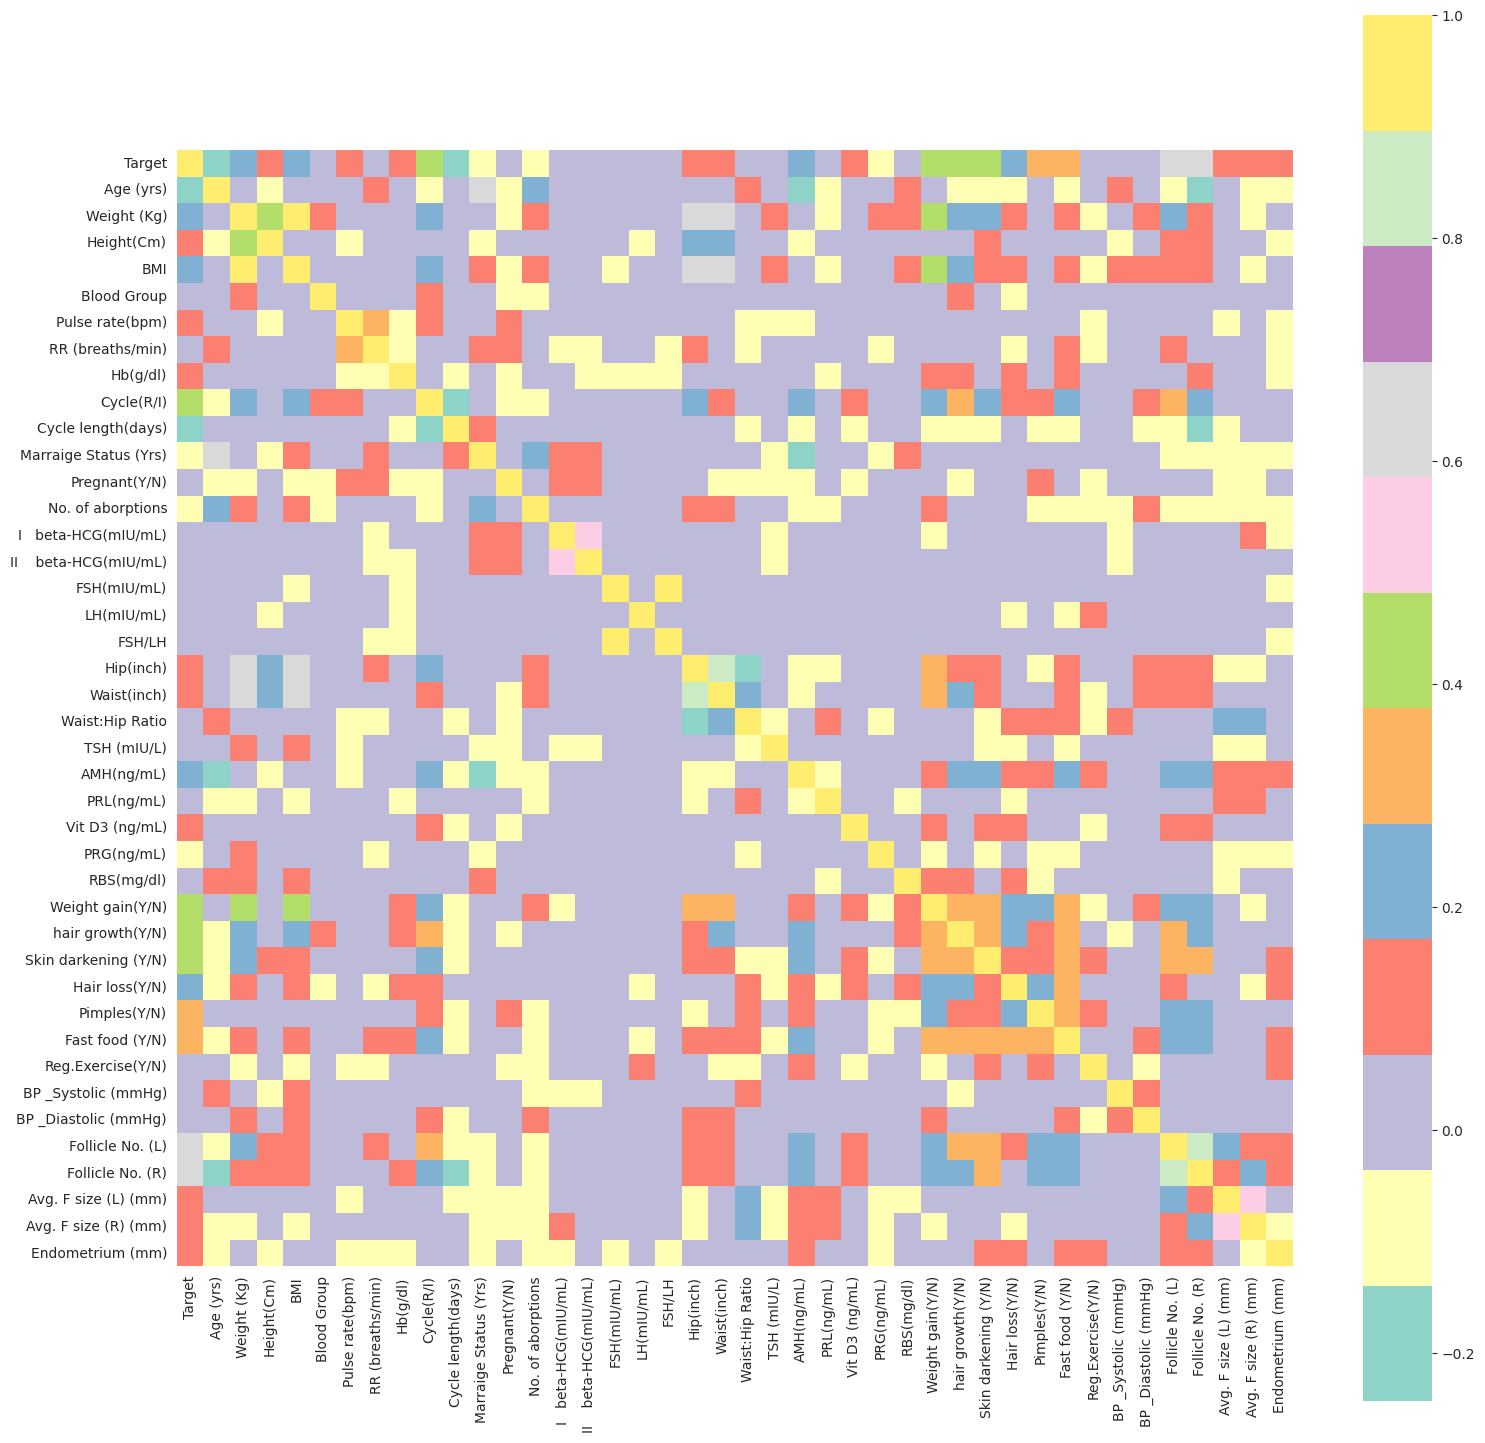

In [68]:
# Examaning a correlation matrix of all the features.

corrmat = data.corr()
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap="Set3", square=True);

In [69]:
# How all the features correlate with the PCOS. 

corrmat['Target'].sort_values(ascending=False)

Target                    1.000000
Follicle No. (R)          0.648327
Follicle No. (L)          0.603346
Skin darkening (Y/N)      0.475733
hair growth(Y/N)          0.464667
Weight gain(Y/N)          0.441047
Cycle(R/I)                0.401644
Fast food (Y/N)           0.376183
Pimples(Y/N)              0.286077
AMH(ng/mL)                0.264141
Weight (Kg)               0.211938
BMI                       0.199534
Hair loss(Y/N)            0.172879
Waist(inch)               0.164598
Hip(inch)                 0.162297
Avg. F size (L) (mm)      0.132992
Endometrium (mm)          0.106648
Avg. F size (R) (mm)      0.097690
Pulse rate(bpm)           0.091821
Hb(g/dl)                  0.087170
Vit D3 (ng/mL)            0.085494
Height(Cm)                0.068254
Reg.Exercise(Y/N)         0.065337
LH(mIU/mL)                0.063879
RBS(mg/dl)                0.048922
BP _Diastolic (mmHg)      0.038032
RR (breaths/min)          0.036928
Blood Group               0.036433
II    beta-HCG(mIU/m

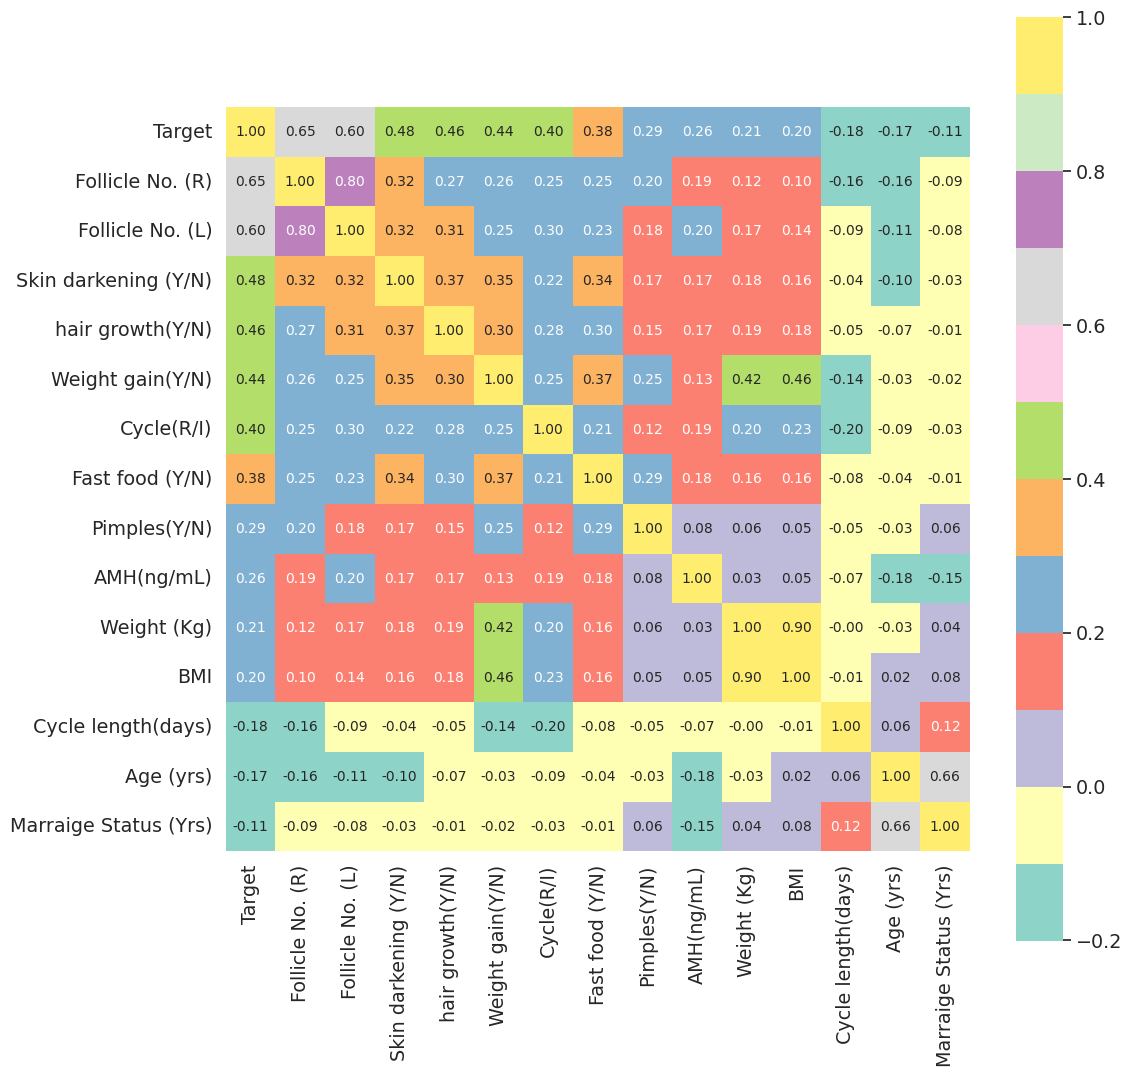

In [70]:
# Having a look at features bearing significant correlation.

plt.figure(figsize=(12,12))
k = 12 #number of variables with positive for heatmap
l = 3 #number of variables with negative for heatmap
cols_p = corrmat.nlargest(k,'Target')['Target'].index 
cols_n = corrmat.nsmallest(l, 'Target')['Target'].index
cols = cols_p.append(cols_n) 

cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True,cmap="Set3", annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

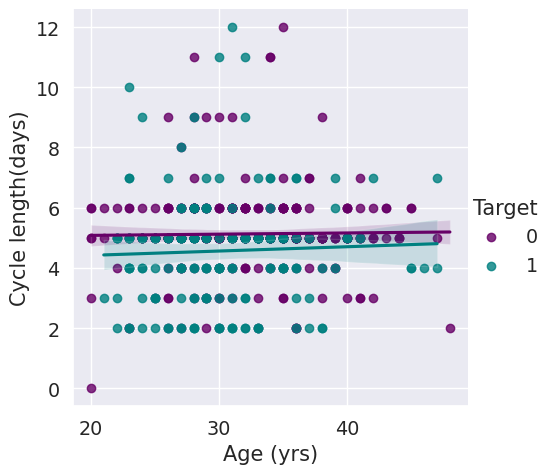

In [71]:
# Length of menstrual phase in PCOS vs normal 

fig=sns.lmplot(data=data,x="Age (yrs)",y="Cycle length(days)", hue="Target",palette=colors)
plt.show(fig)

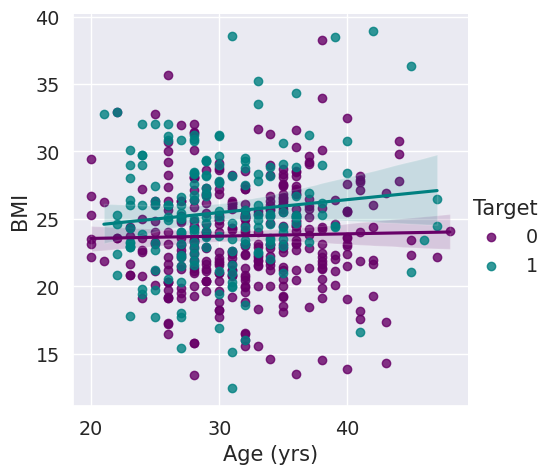

In [72]:
# Pattern of weight gain (BMI) over years in PCOS and Normal. 

fig= sns.lmplot(data =data,x="Age (yrs)",y="BMI", hue="Target", palette= colors )
plt.show(fig)

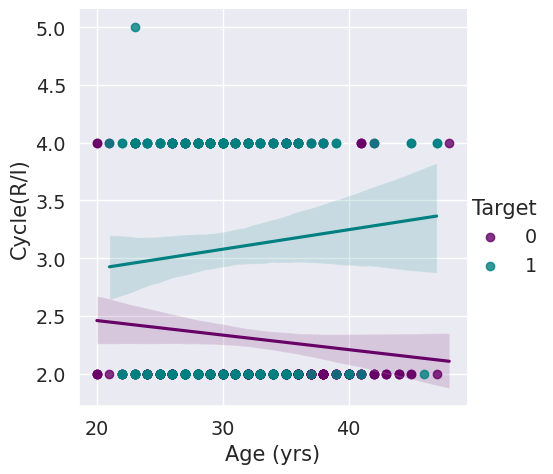

In [73]:
# Cycle IR wrt age 

sns.lmplot(data =data,x="Age (yrs)",y="Cycle(R/I)", hue="Target",palette=colors)
plt.show()

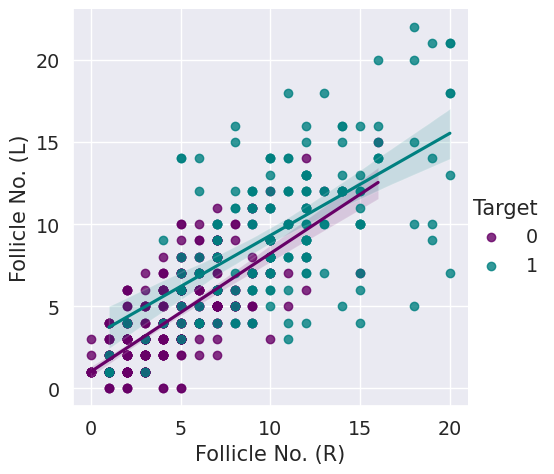

In [74]:
# Distribution of follicles in both ovaries.

sns.lmplot(data =data,x='Follicle No. (R)',y='Follicle No. (L)', hue="Target",palette=colors)
plt.show()

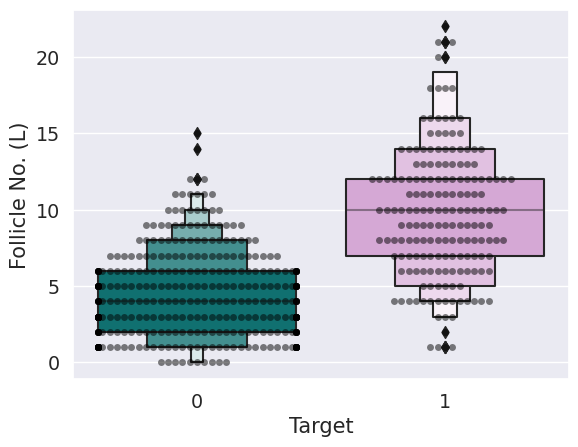

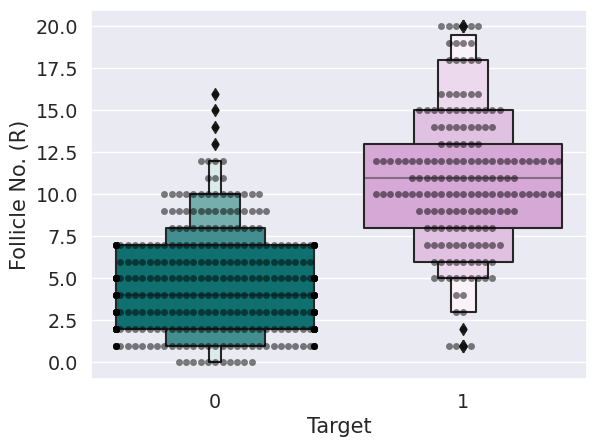

In [75]:
# Exploring the above observation with the help of Boxplot

color = ["teal", "plum"]
features = ["Follicle No. (L)","Follicle No. (R)"]
for i in features:
    sns.swarmplot(x=data["Target"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["Target"], y=data[i], palette=color)
    plt.show()

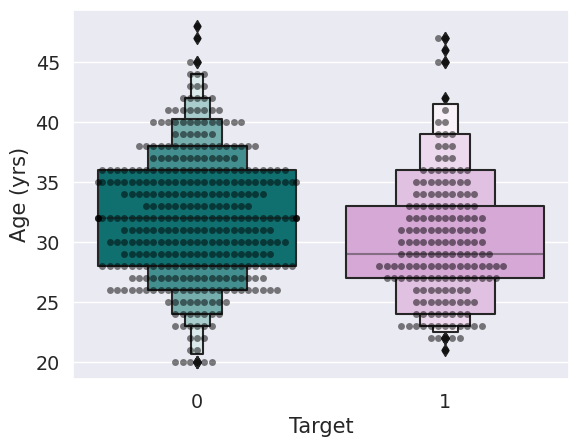

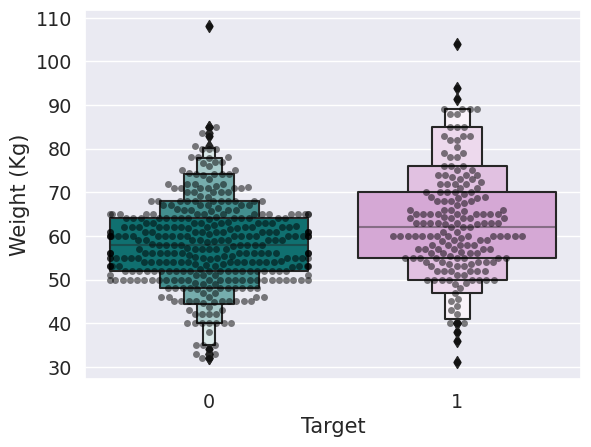

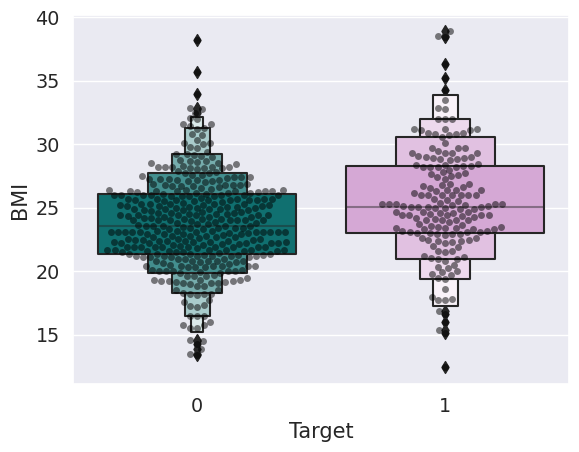

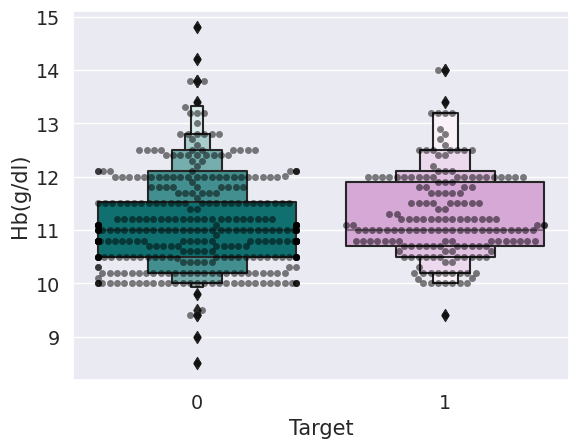

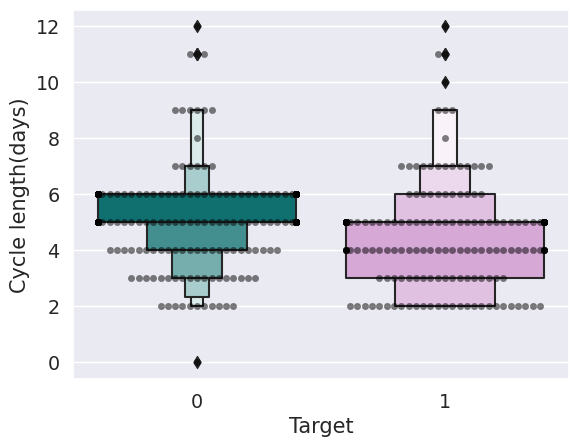

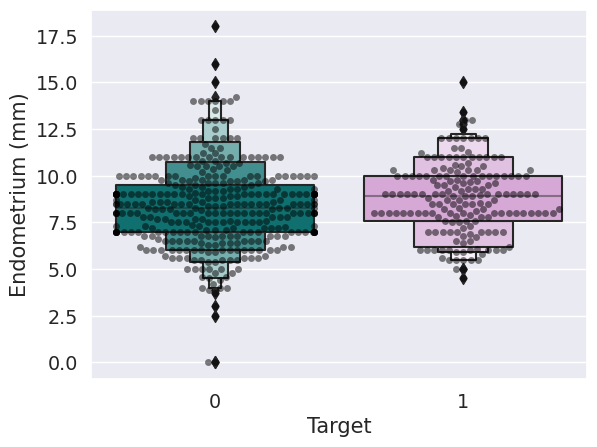

In [76]:
features = ["Age (yrs)","Weight (Kg)", "BMI", "Hb(g/dl)", "Cycle length(days)","Endometrium (mm)" ]
for i in features:
    sns.swarmplot(x=data["Target"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["Target"], y=data[i], palette=color)
    plt.show()

In [77]:
#Assiging the features (X)and target(y).

X= data.drop(labels = ["Target"],axis = 1)
y=data.Target

In [78]:
#Splitting the data into test and training sets.

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [79]:
print("X_train",len(X_train))
print("X_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))

X_train 378
X_test 163
y_train 378
y_test 163


In [80]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
acc_log_train = round(logreg.score(X_train, y_train)*100,2) 
acc_log_test = round(logreg.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_log_train))
print("Testing Accuracy: % {}".format(acc_log_test))

Training Accuracy: % 86.24
Testing Accuracy: % 82.82


In [81]:
random_state = 42
classifier = [DecisionTreeClassifier(random_state = random_state),
             SVC(random_state = random_state),
             RandomForestClassifier(random_state = random_state),
             LogisticRegression(random_state = random_state),
             KNeighborsClassifier()]

# Decision Tree
dt_param_grid = {"min_samples_split" : range(10,500,20),
                "max_depth": range(1,20,2)}

# SVM
svc_param_grid = {"kernel" : ["rbf"],
                 "gamma": [0.001, 0.01, 0.1, 1],
                 "C": [1,10,50,100,200,300,1000]}

# Random Forest
rf_param_grid = {"max_features": ['auto', 'sqrt', 'log2'],
                "n_estimators":[300,500],
                "criterion":["gini"],
                'max_depth' : [4,5,6,7,8,9,10,12],}

# Logistic Regression
logreg_param_grid = {"C":np.logspace(-3,3,7),
                    "penalty": ["l1","l2"]}

# KNN
knn_param_grid = {"n_neighbors": np.linspace(1,19,10, dtype = int).tolist(),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan"]}


classifier_param = [dt_param_grid,
                   svc_param_grid,
                   rf_param_grid,
                   logreg_param_grid,
                   knn_param_grid]

In [82]:
cv_result = []
best_estimators = []
for i in range(len(classifier)):
    clf = GridSearchCV(classifier[i], param_grid=classifier_param[i], cv = StratifiedKFold(n_splits = 10),
                       scoring = "accuracy", n_jobs = -1,verbose = 1)
    clf.fit(X_train,y_train)
    cv_result.append(round(clf.best_score_*100,2))
    best_estimators.append(clf.best_estimator_)
    print(cv_result[i])

Fitting 10 folds for each of 250 candidates, totalling 2500 fits
84.42
Fitting 10 folds for each of 28 candidates, totalling 280 fits
69.86
Fitting 10 folds for each of 48 candidates, totalling 480 fits
89.69
Fitting 10 folds for each of 14 candidates, totalling 140 fits
84.68
Fitting 10 folds for each of 40 candidates, totalling 400 fits
72.23


In [83]:
best_estimators

[DecisionTreeClassifier(max_depth=1, min_samples_split=10, random_state=42),
 SVC(C=10, gamma=0.001, random_state=42),
 RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=500,
                        random_state=42),
 LogisticRegression(C=10.0, random_state=42),
 KNeighborsClassifier(metric='manhattan', n_neighbors=7)]

In [84]:
dt = best_estimators[0]
svm = best_estimators[1]
rf = best_estimators[2]
lr = best_estimators[3]
knn = best_estimators[4]

In [85]:
# XGBRF Classifier
xgb_clf = xgboost.XGBRFClassifier(max_depth=3, random_state=random_state)
xgb_clf.fit(X_train,y_train)
acc_xgb_clf_train = round(xgb_clf.score(X_train, y_train)*100,2) 
acc_xgb_clf_test = round(xgb_clf.score(X_test,y_test)*100,2)
cv_result.append(acc_xgb_clf_train)
print("Training Accuracy: % {}".format(acc_xgb_clf_train))
print("Testing Accuracy: % {}".format(acc_xgb_clf_test))

Training Accuracy: % 92.33
Testing Accuracy: % 86.5


In [86]:
# CatBoost Classifier
cat_clf = CatBoostClassifier()
cat_clf.fit(X_train,y_train)
acc_cat_clf_train = round(cat_clf.score(X_train, y_train)*100,2) 
acc_cat_clf_test = round(cat_clf.score(X_test,y_test)*100,2)
cv_result.append(acc_cat_clf_train)
print("Training Accuracy: % {}".format(acc_cat_clf_train))
print("Testing Accuracy: % {}".format(acc_cat_clf_test))

Learning rate set to 0.0068
0:	learn: 0.6883591	total: 55.1ms	remaining: 55.1s
1:	learn: 0.6821360	total: 59.5ms	remaining: 29.7s
2:	learn: 0.6760629	total: 65.1ms	remaining: 21.6s
3:	learn: 0.6690527	total: 69.1ms	remaining: 17.2s
4:	learn: 0.6608832	total: 75ms	remaining: 14.9s
5:	learn: 0.6558515	total: 79.1ms	remaining: 13.1s
6:	learn: 0.6503546	total: 85.1ms	remaining: 12.1s
7:	learn: 0.6455030	total: 89ms	remaining: 11s
8:	learn: 0.6413042	total: 94.8ms	remaining: 10.4s
9:	learn: 0.6360419	total: 99ms	remaining: 9.8s
10:	learn: 0.6304449	total: 105ms	remaining: 9.42s
11:	learn: 0.6247034	total: 109ms	remaining: 8.96s
12:	learn: 0.6207781	total: 115ms	remaining: 8.72s
13:	learn: 0.6164867	total: 119ms	remaining: 8.39s
14:	learn: 0.6109865	total: 125ms	remaining: 8.19s
15:	learn: 0.6060815	total: 129ms	remaining: 7.93s
16:	learn: 0.6021698	total: 135ms	remaining: 7.78s
17:	learn: 0.5970639	total: 139ms	remaining: 7.57s
18:	learn: 0.5920273	total: 145ms	remaining: 7.5s
19:	learn: 0.

In [87]:
model_list = ['Decision Tree','SVC','RandomForest','Logistic Regression','KNearestNeighbours','XGBRF','CatBoostClassifier']

In [89]:
pip install --upgrade seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


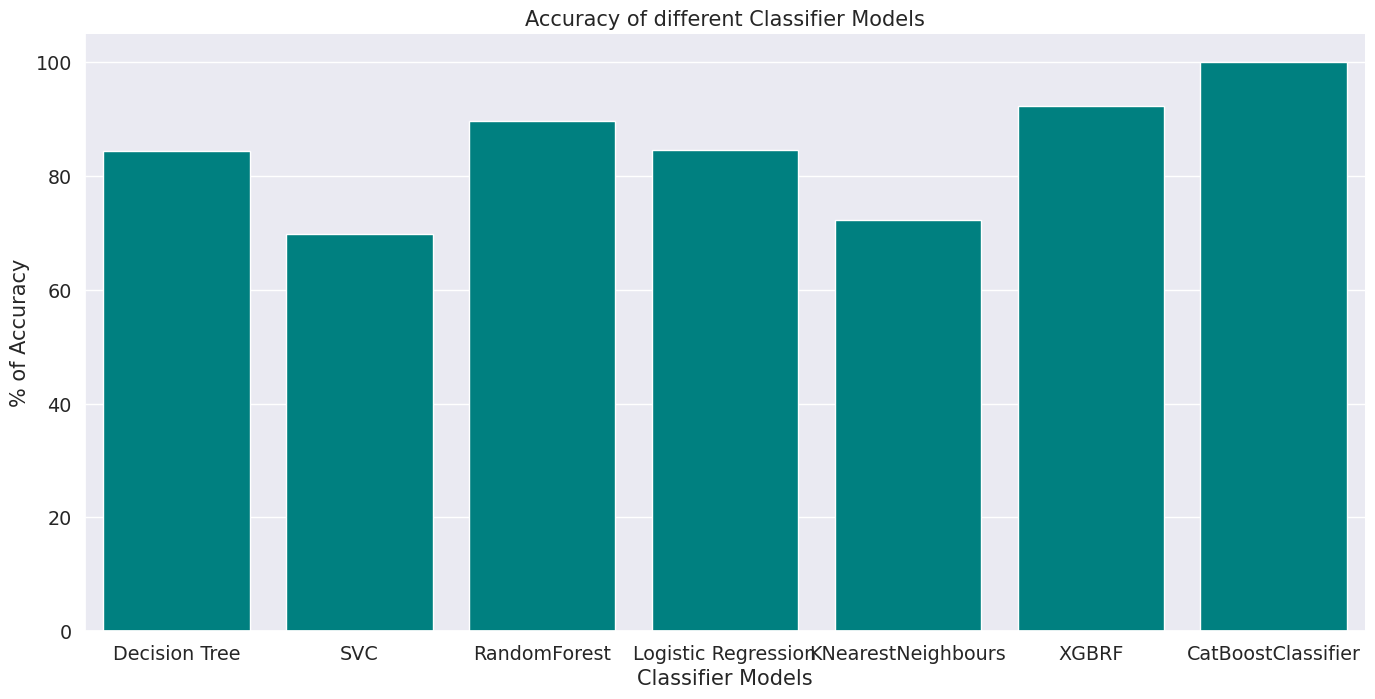

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

fg = sns.catplot(x=model_list, y=cv_result, height=7, aspect=2, color=colors[1], saturation=5, kind='bar', data=data)
plt.title('Accuracy of different Classifier Models')
plt.xlabel('Classifier Models')
plt.ylabel('% of Accuracy')

plt.show()


In [93]:
model=['CatBoostClassifier']

In [94]:
import pickle
pickle.dump(model, open('modelfinal1.pkl', 'wb'))